<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/Centralized-training/Centralized_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split
from torchsummary import summary

import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
print(f"Pytorch Version:{torch.__version__}")

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")


Pytorch Version:2.5.1+cu121
Training on cpu


# Dataloader


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=50000, shuffle=False)

# Get all images in the training set
data = next(iter(trainloader))[0]  # Images only (shape: [50000, 3, 32, 32])

# Calculate mean and std for each channel
mean = data.mean(dim=[0, 2, 3])  # Mean across batches, height, and width
std = data.std(dim=[0, 2, 3])    # Std across batches, height, and width

print(f"Mean: {mean}, Std: {std}")

100%|██████████| 170M/170M [00:03<00:00, 44.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


In [3]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation: random cropping
    transforms.RandomHorizontalFlip(),    # Data augmentation: random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Normalize with CIFAR-10 stats
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(trainset))  # 80% of the dataset for training
val_size = len(trainset) - train_size  # Remaining 20% for validation

train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainloader.dataset)}")
print(f"Validation samples: {len(valloader.dataset)}")
print(f"Test samples: {len(testloader.dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Training samples: 40000
Validation samples: 10000
Test samples: 10000


In [4]:
print("CIFAR-10 Classes:", trainset.classes)

CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# train test Func


/+ StepLR scheduler

In [10]:
from tqdm import tqdm  # For progress bars

def train(
    net,
    trainloader,
    valloader,
    optimizer,
    step_size,
    epochs: int,
    verbose=False
):

    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= step_size , gamma=0.5)  # Optional scheduler
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Training loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {lr}")

        net.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        # Training Phase
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            try:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Metrics
                train_loss += loss.item()
                train_total += labels.size(0)
                predictions = torch.argmax(outputs, dim=1)
                train_correct += (predictions == labels).sum().item()
            except Exception as e:
                print(f"Error in training step: {e}")

        if (epoch + 1) % 10 == 0:
            filename = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save(net, filename)
            print(f"Entire model saved to {filename}")

        # Compute averages
        train_loss /= len(trainloader)
        train_acc = train_correct / train_total

        # Validation Phase
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(valloader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                try:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = net(images)
                    loss = criterion(outputs, labels)

                    # Metrics
                    val_loss += loss.item()
                    val_total += labels.size(0)
                    predictions = torch.argmax(outputs, dim=1)
                    val_correct += (predictions == labels).sum().item()
                except Exception as e:
                    print(f"Error in validation step: {e}")

        # Compute averages
        val_loss /= len(valloader)
        val_acc = val_correct / val_total

        # Step the scheduler
        scheduler.step()

        # Save metrics to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Verbose logging
        if verbose:
            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
                f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        if val_acc >= 0.90:
              print(f"Early stopping: Validation accuracy reached {accuracy_threshold*100}%")
              break

    return history


In [6]:
def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    net.eval()  # Set the model to evaluation mode
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in tqdm(testloader, desc="Testing"):
            try:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = net(images)
                loss = criterion(outputs, labels)

                # Metrics
                test_loss += loss.item()
                test_total += labels.size(0)
                predictions = torch.argmax(outputs, dim=1)
                test_correct += (predictions == labels).sum().item()
            except Exception as e:
                print(f"Error in testing step: {e}")

    # Compute averages
    test_loss /= len(testloader)
    test_acc = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc


# Model 1

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset(self):
      for layer in self.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
          layer.reset_parameters()

In [ ]:
model = Net()
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 62006


## Run

Epoch 1/100 - Learning Rate: 0.01


Epoch 1/100 (Validation): 100%|██████████| 79/79 [00:07<00:00, 11.00it/s]


Epoch 1/100 - Train Loss: 2.0844, Train Acc: 0.2241 - Val Loss: 1.8392, Val Acc: 0.3376
Epoch 2/100 - Learning Rate: 0.01


Epoch 2/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


Epoch 2/100 - Train Loss: 1.7027, Train Acc: 0.3694 - Val Loss: 1.5947, Val Acc: 0.4212
Epoch 3/100 - Learning Rate: 0.01


Epoch 3/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.57it/s]


Epoch 3/100 - Train Loss: 1.5625, Train Acc: 0.4275 - Val Loss: 1.5817, Val Acc: 0.4286
Epoch 4/100 - Learning Rate: 0.01


Epoch 4/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.14it/s]


Epoch 4/100 - Train Loss: 1.4610, Train Acc: 0.4684 - Val Loss: 1.4098, Val Acc: 0.4933
Epoch 5/100 - Learning Rate: 0.01


Epoch 5/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.30it/s]


Epoch 5/100 - Train Loss: 1.4020, Train Acc: 0.4966 - Val Loss: 1.3835, Val Acc: 0.4997
Epoch 6/100 - Learning Rate: 0.01


Epoch 6/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.32it/s]


Epoch 6/100 - Train Loss: 1.3595, Train Acc: 0.5115 - Val Loss: 1.3242, Val Acc: 0.5220
Epoch 7/100 - Learning Rate: 0.01


Epoch 7/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.19it/s]


Epoch 7/100 - Train Loss: 1.3134, Train Acc: 0.5290 - Val Loss: 1.2999, Val Acc: 0.5373
Epoch 8/100 - Learning Rate: 0.01


Epoch 8/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.47it/s]


Epoch 8/100 - Train Loss: 1.2767, Train Acc: 0.5415 - Val Loss: 1.2629, Val Acc: 0.5516
Epoch 9/100 - Learning Rate: 0.01


Epoch 9/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]


Epoch 9/100 - Train Loss: 1.2387, Train Acc: 0.5572 - Val Loss: 1.2806, Val Acc: 0.5428
Epoch 10/100 - Learning Rate: 0.01


Epoch 10/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.28it/s]


Epoch 10/100 - Train Loss: 1.2276, Train Acc: 0.5593 - Val Loss: 1.2445, Val Acc: 0.5541
Epoch 11/100 - Learning Rate: 0.01


Epoch 11/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.75it/s]


Epoch 11/100 - Train Loss: 1.1961, Train Acc: 0.5745 - Val Loss: 1.2845, Val Acc: 0.5429
Epoch 12/100 - Learning Rate: 0.01


Epoch 12/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.91it/s]


Epoch 12/100 - Train Loss: 1.1814, Train Acc: 0.5803 - Val Loss: 1.2104, Val Acc: 0.5754
Epoch 13/100 - Learning Rate: 0.01


Epoch 13/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.76it/s]


Epoch 13/100 - Train Loss: 1.1557, Train Acc: 0.5918 - Val Loss: 1.1527, Val Acc: 0.5890
Epoch 14/100 - Learning Rate: 0.01


Epoch 14/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.76it/s]


Epoch 14/100 - Train Loss: 1.1397, Train Acc: 0.5957 - Val Loss: 1.1774, Val Acc: 0.5801
Epoch 15/100 - Learning Rate: 0.01


Epoch 15/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.17it/s]


Epoch 15/100 - Train Loss: 1.1238, Train Acc: 0.6038 - Val Loss: 1.1299, Val Acc: 0.6026
Epoch 16/100 - Learning Rate: 0.01


Epoch 16/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.93it/s]


Epoch 16/100 - Train Loss: 1.1125, Train Acc: 0.6076 - Val Loss: 1.1310, Val Acc: 0.6090
Epoch 17/100 - Learning Rate: 0.01


Epoch 17/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.87it/s]


Epoch 17/100 - Train Loss: 1.0967, Train Acc: 0.6122 - Val Loss: 1.1340, Val Acc: 0.6014
Epoch 18/100 - Learning Rate: 0.01


Epoch 18/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.63it/s]


Epoch 18/100 - Train Loss: 1.0864, Train Acc: 0.6150 - Val Loss: 1.1306, Val Acc: 0.6056
Epoch 19/100 - Learning Rate: 0.01


Epoch 19/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.04it/s]


Epoch 19/100 - Train Loss: 1.0872, Train Acc: 0.6165 - Val Loss: 1.0985, Val Acc: 0.6189
Epoch 20/100 - Learning Rate: 0.01


Epoch 20/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.06it/s]


Epoch 20/100 - Train Loss: 1.0778, Train Acc: 0.6201 - Val Loss: 1.1948, Val Acc: 0.5751
Epoch 21/100 - Learning Rate: 0.01


Epoch 21/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.92it/s]


Epoch 21/100 - Train Loss: 1.0590, Train Acc: 0.6257 - Val Loss: 1.0557, Val Acc: 0.6283
Epoch 22/100 - Learning Rate: 0.01


Epoch 22/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.02it/s]


Epoch 22/100 - Train Loss: 1.0479, Train Acc: 0.6295 - Val Loss: 1.0679, Val Acc: 0.6226
Epoch 23/100 - Learning Rate: 0.01


Epoch 23/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.89it/s]


Epoch 23/100 - Train Loss: 1.0327, Train Acc: 0.6344 - Val Loss: 1.0709, Val Acc: 0.6220
Epoch 24/100 - Learning Rate: 0.01


Epoch 24/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.88it/s]


Epoch 24/100 - Train Loss: 1.0358, Train Acc: 0.6332 - Val Loss: 1.0769, Val Acc: 0.6243
Epoch 25/100 - Learning Rate: 0.01


Epoch 25/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.67it/s]


Epoch 25/100 - Train Loss: 1.0302, Train Acc: 0.6330 - Val Loss: 1.0853, Val Acc: 0.6176
Epoch 26/100 - Learning Rate: 0.01


Epoch 26/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.63it/s]


Epoch 26/100 - Train Loss: 1.0161, Train Acc: 0.6422 - Val Loss: 1.0541, Val Acc: 0.6273
Epoch 27/100 - Learning Rate: 0.01


Epoch 27/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.05it/s]


Epoch 27/100 - Train Loss: 1.0126, Train Acc: 0.6431 - Val Loss: 1.1035, Val Acc: 0.6141
Epoch 28/100 - Learning Rate: 0.01


Epoch 28/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.90it/s]


Epoch 28/100 - Train Loss: 1.0171, Train Acc: 0.6408 - Val Loss: 1.0488, Val Acc: 0.6353
Epoch 29/100 - Learning Rate: 0.01


Epoch 29/100 (Validation): 100%|██████████| 79/79 [00:07<00:00, 10.19it/s]


Epoch 29/100 - Train Loss: 1.0001, Train Acc: 0.6487 - Val Loss: 1.0087, Val Acc: 0.6471
Epoch 30/100 - Learning Rate: 0.01


Epoch 30/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]


Epoch 30/100 - Train Loss: 0.9986, Train Acc: 0.6486 - Val Loss: 1.0224, Val Acc: 0.6384
Epoch 31/100 - Learning Rate: 0.01


Epoch 31/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]


Epoch 31/100 - Train Loss: 0.9832, Train Acc: 0.6543 - Val Loss: 1.0975, Val Acc: 0.6193
Epoch 32/100 - Learning Rate: 0.01


Epoch 32/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


Epoch 32/100 - Train Loss: 0.9869, Train Acc: 0.6517 - Val Loss: 1.0402, Val Acc: 0.6362
Epoch 33/100 - Learning Rate: 0.01


Epoch 33/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.41it/s]


Epoch 33/100 - Train Loss: 0.9857, Train Acc: 0.6539 - Val Loss: 1.0644, Val Acc: 0.6235
Epoch 34/100 - Learning Rate: 0.01


Epoch 34/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.51it/s]


Epoch 34/100 - Train Loss: 0.9741, Train Acc: 0.6596 - Val Loss: 0.9931, Val Acc: 0.6493
Epoch 35/100 - Learning Rate: 0.01


Epoch 35/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.53it/s]


Epoch 35/100 - Train Loss: 0.9766, Train Acc: 0.6574 - Val Loss: 1.0311, Val Acc: 0.6345
Epoch 36/100 - Learning Rate: 0.01


Epoch 36/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Epoch 36/100 - Train Loss: 0.9657, Train Acc: 0.6623 - Val Loss: 1.0366, Val Acc: 0.6380
Epoch 37/100 - Learning Rate: 0.01


Epoch 37/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.47it/s]


Epoch 37/100 - Train Loss: 0.9594, Train Acc: 0.6629 - Val Loss: 1.0243, Val Acc: 0.6455
Epoch 38/100 - Learning Rate: 0.01


Epoch 38/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


Epoch 38/100 - Train Loss: 0.9549, Train Acc: 0.6657 - Val Loss: 0.9893, Val Acc: 0.6514
Epoch 39/100 - Learning Rate: 0.01


Epoch 39/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 13.12it/s]


Epoch 39/100 - Train Loss: 0.9541, Train Acc: 0.6641 - Val Loss: 0.9893, Val Acc: 0.6582
Epoch 40/100 - Learning Rate: 0.01


Epoch 40/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 13.02it/s]


Epoch 40/100 - Train Loss: 0.9649, Train Acc: 0.6620 - Val Loss: 0.9964, Val Acc: 0.6470
Epoch 41/100 - Learning Rate: 0.01


Epoch 41/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.31it/s]


Epoch 41/100 - Train Loss: 0.9485, Train Acc: 0.6676 - Val Loss: 1.0116, Val Acc: 0.6436
Epoch 42/100 - Learning Rate: 0.01


Epoch 42/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 42/100 - Train Loss: 0.9457, Train Acc: 0.6707 - Val Loss: 1.0255, Val Acc: 0.6419
Epoch 43/100 - Learning Rate: 0.01


Epoch 43/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.28it/s]


Epoch 43/100 - Train Loss: 0.9569, Train Acc: 0.6604 - Val Loss: 0.9746, Val Acc: 0.6626
Epoch 44/100 - Learning Rate: 0.01


Epoch 44/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.02it/s]


Epoch 44/100 - Train Loss: 0.9322, Train Acc: 0.6738 - Val Loss: 0.9909, Val Acc: 0.6581
Epoch 45/100 - Learning Rate: 0.01


Epoch 45/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.66it/s]


Epoch 45/100 - Train Loss: 0.9333, Train Acc: 0.6732 - Val Loss: 0.9983, Val Acc: 0.6496
Epoch 46/100 - Learning Rate: 0.01


Epoch 46/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.12it/s]


Epoch 46/100 - Train Loss: 0.9361, Train Acc: 0.6692 - Val Loss: 0.9947, Val Acc: 0.6519
Epoch 47/100 - Learning Rate: 0.01


Epoch 47/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.77it/s]


Epoch 47/100 - Train Loss: 0.9315, Train Acc: 0.6733 - Val Loss: 1.0021, Val Acc: 0.6421
Epoch 48/100 - Learning Rate: 0.01


Epoch 48/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.07it/s]


Epoch 48/100 - Train Loss: 0.9350, Train Acc: 0.6717 - Val Loss: 0.9635, Val Acc: 0.6608
Epoch 49/100 - Learning Rate: 0.01


Epoch 49/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.83it/s]


Epoch 49/100 - Train Loss: 0.9274, Train Acc: 0.6741 - Val Loss: 0.9812, Val Acc: 0.6569
Epoch 50/100 - Learning Rate: 0.01


Epoch 50/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.07it/s]


Epoch 50/100 - Train Loss: 0.9262, Train Acc: 0.6747 - Val Loss: 1.0015, Val Acc: 0.6521
Epoch 51/100 - Learning Rate: 0.005


Epoch 51/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.13it/s]


Epoch 51/100 - Train Loss: 0.8747, Train Acc: 0.6938 - Val Loss: 0.9328, Val Acc: 0.6728
Epoch 52/100 - Learning Rate: 0.005


Epoch 52/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.82it/s]


Epoch 52/100 - Train Loss: 0.8600, Train Acc: 0.6967 - Val Loss: 0.9392, Val Acc: 0.6711
Epoch 53/100 - Learning Rate: 0.005


Epoch 53/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.97it/s]


Epoch 53/100 - Train Loss: 0.8621, Train Acc: 0.6985 - Val Loss: 0.9234, Val Acc: 0.6762
Epoch 54/100 - Learning Rate: 0.005


Epoch 54/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.44it/s]


Epoch 54/100 - Train Loss: 0.8516, Train Acc: 0.7015 - Val Loss: 0.9098, Val Acc: 0.6758
Epoch 55/100 - Learning Rate: 0.005


Epoch 55/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.44it/s]


Epoch 55/100 - Train Loss: 0.8538, Train Acc: 0.6993 - Val Loss: 0.9190, Val Acc: 0.6795
Epoch 56/100 - Learning Rate: 0.005


Epoch 56/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.86it/s]


Epoch 56/100 - Train Loss: 0.8449, Train Acc: 0.7029 - Val Loss: 0.9295, Val Acc: 0.6753
Epoch 57/100 - Learning Rate: 0.005


Epoch 57/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.89it/s]


Epoch 57/100 - Train Loss: 0.8459, Train Acc: 0.7025 - Val Loss: 0.9052, Val Acc: 0.6847
Epoch 58/100 - Learning Rate: 0.005


Epoch 58/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.31it/s]


Epoch 58/100 - Train Loss: 0.8425, Train Acc: 0.7070 - Val Loss: 0.9295, Val Acc: 0.6728
Epoch 59/100 - Learning Rate: 0.005


Epoch 59/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


Epoch 59/100 - Train Loss: 0.8407, Train Acc: 0.7035 - Val Loss: 0.9246, Val Acc: 0.6760
Epoch 60/100 - Learning Rate: 0.005


Epoch 60/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 60/100 - Train Loss: 0.8432, Train Acc: 0.7042 - Val Loss: 0.9035, Val Acc: 0.6869
Epoch 61/100 - Learning Rate: 0.005


Epoch 61/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 61/100 - Train Loss: 0.8477, Train Acc: 0.6998 - Val Loss: 0.9085, Val Acc: 0.6872
Epoch 62/100 - Learning Rate: 0.005


Epoch 62/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.27it/s]


Epoch 62/100 - Train Loss: 0.8419, Train Acc: 0.7061 - Val Loss: 0.9212, Val Acc: 0.6783
Epoch 63/100 - Learning Rate: 0.005


Epoch 63/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.31it/s]


Epoch 63/100 - Train Loss: 0.8497, Train Acc: 0.7016 - Val Loss: 0.9202, Val Acc: 0.6777
Epoch 64/100 - Learning Rate: 0.005


Epoch 64/100 (Validation): 100%|██████████| 79/79 [00:08<00:00,  9.02it/s]


Epoch 64/100 - Train Loss: 0.8360, Train Acc: 0.7044 - Val Loss: 0.9248, Val Acc: 0.6775
Epoch 65/100 - Learning Rate: 0.005


Epoch 65/100 (Validation): 100%|██████████| 79/79 [00:08<00:00,  8.83it/s]


Epoch 65/100 - Train Loss: 0.8415, Train Acc: 0.7038 - Val Loss: 0.9089, Val Acc: 0.6788
Epoch 66/100 - Learning Rate: 0.005


Epoch 66/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 15.97it/s]


Epoch 66/100 - Train Loss: 0.8366, Train Acc: 0.7053 - Val Loss: 0.9306, Val Acc: 0.6736
Epoch 67/100 - Learning Rate: 0.005


Epoch 67/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.03it/s]


Epoch 67/100 - Train Loss: 0.8346, Train Acc: 0.7083 - Val Loss: 0.9062, Val Acc: 0.6838
Epoch 68/100 - Learning Rate: 0.005


Epoch 68/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.82it/s]


Epoch 68/100 - Train Loss: 0.8379, Train Acc: 0.7054 - Val Loss: 0.9201, Val Acc: 0.6810
Epoch 69/100 - Learning Rate: 0.005


Epoch 69/100 (Validation): 100%|██████████| 79/79 [00:07<00:00, 11.13it/s]


Epoch 69/100 - Train Loss: 0.8362, Train Acc: 0.7065 - Val Loss: 0.8795, Val Acc: 0.6912
Epoch 70/100 - Learning Rate: 0.005


Epoch 70/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.87it/s]


Epoch 70/100 - Train Loss: 0.8336, Train Acc: 0.7091 - Val Loss: 0.9245, Val Acc: 0.6751
Epoch 71/100 - Learning Rate: 0.005


Epoch 71/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


Epoch 71/100 - Train Loss: 0.8247, Train Acc: 0.7063 - Val Loss: 0.8997, Val Acc: 0.6874
Epoch 72/100 - Learning Rate: 0.005


Epoch 72/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.10it/s]


Epoch 72/100 - Train Loss: 0.8273, Train Acc: 0.7101 - Val Loss: 0.9135, Val Acc: 0.6816
Epoch 73/100 - Learning Rate: 0.005


Epoch 73/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Epoch 73/100 - Train Loss: 0.8311, Train Acc: 0.7086 - Val Loss: 0.8999, Val Acc: 0.6855
Epoch 74/100 - Learning Rate: 0.005


Epoch 74/100 (Validation): 100%|██████████| 79/79 [00:07<00:00, 10.08it/s]


Epoch 74/100 - Train Loss: 0.8262, Train Acc: 0.7105 - Val Loss: 0.9040, Val Acc: 0.6837
Epoch 75/100 - Learning Rate: 0.005


Epoch 75/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.28it/s]


Epoch 75/100 - Train Loss: 0.8310, Train Acc: 0.7092 - Val Loss: 0.9113, Val Acc: 0.6777
Epoch 76/100 - Learning Rate: 0.005


Epoch 76/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.68it/s]


Epoch 76/100 - Train Loss: 0.8295, Train Acc: 0.7083 - Val Loss: 0.9337, Val Acc: 0.6722
Epoch 77/100 - Learning Rate: 0.005


Epoch 77/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.67it/s]


Epoch 77/100 - Train Loss: 0.8202, Train Acc: 0.7128 - Val Loss: 0.9123, Val Acc: 0.6821
Epoch 78/100 - Learning Rate: 0.005


Epoch 78/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.36it/s]


Epoch 78/100 - Train Loss: 0.8183, Train Acc: 0.7120 - Val Loss: 0.8975, Val Acc: 0.6876
Epoch 79/100 - Learning Rate: 0.005


Epoch 79/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.81it/s]


Epoch 79/100 - Train Loss: 0.8280, Train Acc: 0.7115 - Val Loss: 0.8973, Val Acc: 0.6885
Epoch 80/100 - Learning Rate: 0.005


Epoch 80/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.52it/s]


Epoch 80/100 - Train Loss: 0.8290, Train Acc: 0.7086 - Val Loss: 0.9058, Val Acc: 0.6834
Epoch 81/100 - Learning Rate: 0.005


Epoch 81/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.37it/s]


Epoch 81/100 - Train Loss: 0.8246, Train Acc: 0.7107 - Val Loss: 0.9073, Val Acc: 0.6825
Epoch 82/100 - Learning Rate: 0.005


Epoch 82/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.86it/s]


Epoch 82/100 - Train Loss: 0.8276, Train Acc: 0.7084 - Val Loss: 0.8905, Val Acc: 0.6857
Epoch 83/100 - Learning Rate: 0.005


Epoch 83/100 (Validation): 100%|██████████| 79/79 [00:07<00:00, 11.22it/s]


Epoch 83/100 - Train Loss: 0.8227, Train Acc: 0.7104 - Val Loss: 0.9168, Val Acc: 0.6783
Epoch 84/100 - Learning Rate: 0.005


Epoch 84/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.85it/s]


Epoch 84/100 - Train Loss: 0.8238, Train Acc: 0.7096 - Val Loss: 0.8919, Val Acc: 0.6905
Epoch 85/100 - Learning Rate: 0.005


Epoch 85/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.64it/s]


Epoch 85/100 - Train Loss: 0.8191, Train Acc: 0.7122 - Val Loss: 0.9266, Val Acc: 0.6760
Epoch 86/100 - Learning Rate: 0.005


Epoch 86/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


Epoch 86/100 - Train Loss: 0.8189, Train Acc: 0.7083 - Val Loss: 0.9190, Val Acc: 0.6833
Epoch 87/100 - Learning Rate: 0.005


Epoch 87/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.01it/s]


Epoch 87/100 - Train Loss: 0.8127, Train Acc: 0.7125 - Val Loss: 0.8674, Val Acc: 0.6989
Epoch 88/100 - Learning Rate: 0.005


Epoch 88/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.50it/s]


Epoch 88/100 - Train Loss: 0.8138, Train Acc: 0.7156 - Val Loss: 0.9183, Val Acc: 0.6808
Epoch 89/100 - Learning Rate: 0.005


Epoch 89/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.44it/s]


Epoch 89/100 - Train Loss: 0.8176, Train Acc: 0.7116 - Val Loss: 0.9523, Val Acc: 0.6714
Epoch 90/100 - Learning Rate: 0.005


Epoch 90/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


Epoch 90/100 - Train Loss: 0.8110, Train Acc: 0.7153 - Val Loss: 0.8798, Val Acc: 0.6910
Epoch 91/100 - Learning Rate: 0.005


Epoch 91/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


Epoch 91/100 - Train Loss: 0.8101, Train Acc: 0.7183 - Val Loss: 0.9385, Val Acc: 0.6714
Epoch 92/100 - Learning Rate: 0.005


Epoch 92/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.77it/s]


Epoch 92/100 - Train Loss: 0.8106, Train Acc: 0.7156 - Val Loss: 0.8866, Val Acc: 0.6904
Epoch 93/100 - Learning Rate: 0.005


Epoch 93/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 93/100 - Train Loss: 0.8050, Train Acc: 0.7182 - Val Loss: 0.8907, Val Acc: 0.6893
Epoch 94/100 - Learning Rate: 0.005


Epoch 94/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.54it/s]


Epoch 94/100 - Train Loss: 0.8171, Train Acc: 0.7137 - Val Loss: 0.9028, Val Acc: 0.6856
Epoch 95/100 - Learning Rate: 0.005


Epoch 95/100 (Validation): 100%|██████████| 79/79 [00:06<00:00, 12.39it/s]


Epoch 95/100 - Train Loss: 0.8068, Train Acc: 0.7161 - Val Loss: 0.9031, Val Acc: 0.6819
Epoch 96/100 - Learning Rate: 0.005


Epoch 96/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.06it/s]


Epoch 96/100 - Train Loss: 0.8106, Train Acc: 0.7131 - Val Loss: 0.9008, Val Acc: 0.6841
Epoch 97/100 - Learning Rate: 0.005


Epoch 97/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.52it/s]


Epoch 97/100 - Train Loss: 0.8067, Train Acc: 0.7162 - Val Loss: 0.8999, Val Acc: 0.6873
Epoch 98/100 - Learning Rate: 0.005


Epoch 98/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.44it/s]


Epoch 98/100 - Train Loss: 0.8150, Train Acc: 0.7156 - Val Loss: 0.9071, Val Acc: 0.6834
Epoch 99/100 - Learning Rate: 0.005


Epoch 99/100 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.17it/s]


Epoch 99/100 - Train Loss: 0.8017, Train Acc: 0.7187 - Val Loss: 0.8754, Val Acc: 0.6954
Epoch 100/100 - Learning Rate: 0.005


Epoch 100/100 (Validation): 100%|██████████| 79/79 [00:05<00:00, 15.32it/s]


Epoch 100/100 - Train Loss: 0.8136, Train Acc: 0.7150 - Val Loss: 0.8771, Val Acc: 0.6932


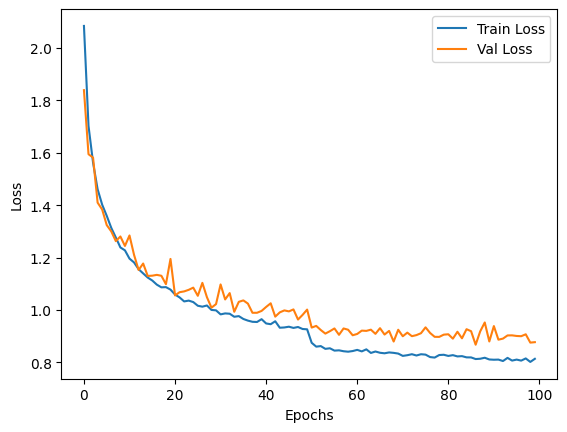

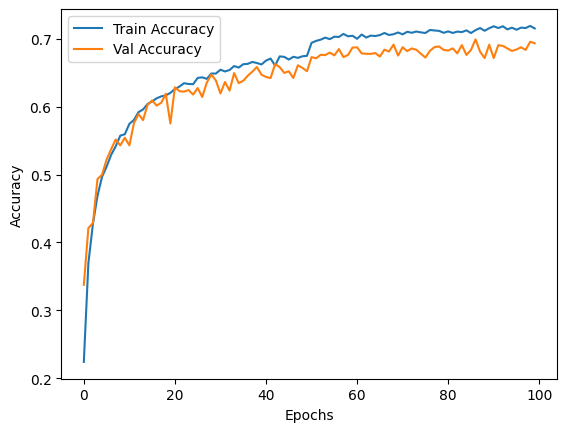

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.reset()  # Reset the model

model = Net().to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

history = train(model, trainloader, valloader, optimizer,step_size=50 , epochs=100, verbose=True)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## test

In [ ]:
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
test_loss, test_acc = test(model, testloader)


Testing: 100%|██████████| 79/79 [00:06<00:00, 11.87it/s]

Test Loss: 0.8985, Test Accuracy: 0.6894


## save model

In [ ]:
filename = 'cifar10_model.pth'

torch.save(model.state_dict(), filename)
print(f"Model saved to {filename}")

Model saved to cifar10_model.pth


In [ ]:
# net = torch.load(filename)
# net.eval()
# print(f"Model loaded from {filename}")

## statistics


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()  # Set model to evaluation mode
all_labels = []
all_preds = []

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Computing Confusion Matrix"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Collect all true labels
        all_preds.extend(preds.cpu().numpy())    # Collect all predictions

        # Find misclassified images
        incorrect = preds != labels
        misclassified_images.extend(images[incorrect].cpu())  # Collect misclassified images
        misclassified_labels.extend(labels[incorrect].cpu())  # True labels of misclassified images
        misclassified_preds.extend(preds[incorrect].cpu())  # Predicted labels of misclassified images



Computing Confusion Matrix: 100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


Accuracy for class 0: 0.76
Accuracy for class 1: 0.78
Accuracy for class 2: 0.61
Accuracy for class 3: 0.41
Accuracy for class 4: 0.65
Accuracy for class 5: 0.57
Accuracy for class 6: 0.81
Accuracy for class 7: 0.73
Accuracy for class 8: 0.82
Accuracy for class 9: 0.76


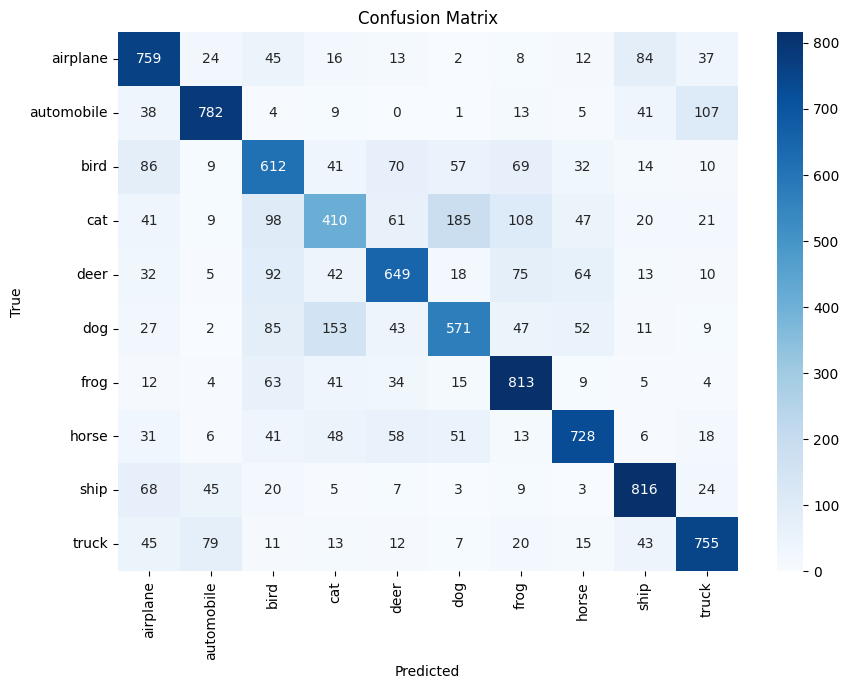

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy for each class
class_accuracies = np.diag(cm) / cm.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {acc:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testloader.dataset.classes, yticklabels=testloader.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

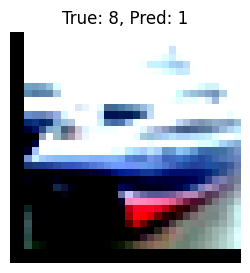

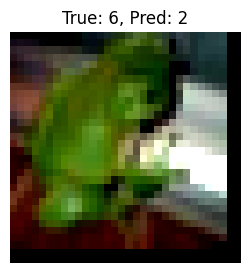

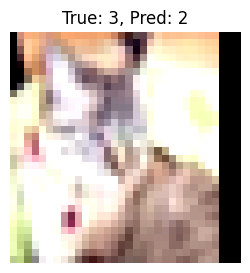

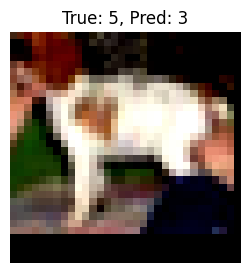

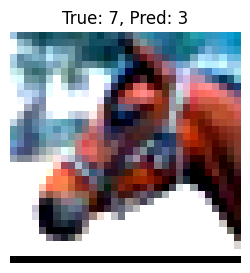

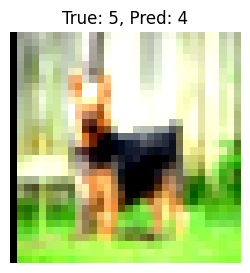

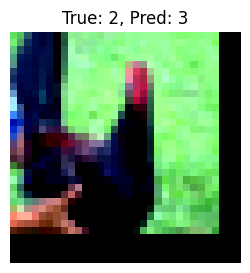

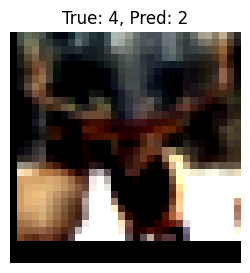

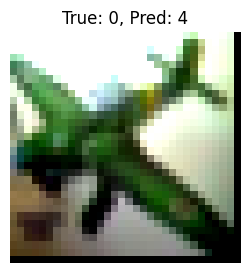

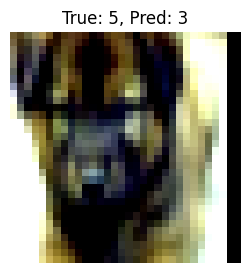

In [ ]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

num_images = 10

for i in range(num_images):
    # Create a new figure for each image
    plt.figure(figsize=(3, 3))

    image = misclassified_images[i].permute(1, 2, 0)  # Convert to (H, W, C)
    image = image * std + mean  # Unnormalize
    image = image.numpy()  # Convert to numpy
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

    plt.imshow(image)
    plt.title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
    plt.axis('off')  # Hide axes
    plt.show()  # Show each image independently

# Model 2



## ShufflnetV2

In [ ]:
from torchvision.models import shufflenet_v2_x1_0

model_2 = shufflenet_v2_x1_0(pretrained=True)

num_classes = 10
model_2.fc = torch.nn.Linear(model_2.fc.in_features, num_classes)

num_parameters = sum(value.numel() for value in model_2.state_dict().values())
print(f"Number of parameters: {num_parameters / 10**6:.2f}M")


Number of parameters: 1.28M


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## freeze layers

In [ ]:
for name, param in model_2.named_parameters():
    if "stage3" in name:
        param.requires_grad = False

for name, param in model_2.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.0.weight: requires_grad=False
conv1.1.weight: requires_grad=False
conv1.1.bias: requires_grad=False
stage2.0.branch1.0.weight: requires_grad=True
stage2.0.branch1.1.weight: requires_grad=True
stage2.0.branch1.1.bias: requires_grad=True
stage2.0.branch1.2.weight: requires_grad=True
stage2.0.branch1.3.weight: requires_grad=True
stage2.0.branch1.3.bias: requires_grad=True
stage2.0.branch2.0.weight: requires_grad=True
stage2.0.branch2.1.weight: requires_grad=True
stage2.0.branch2.1.bias: requires_grad=True
stage2.0.branch2.3.weight: requires_grad=True
stage2.0.branch2.4.weight: requires_grad=True
stage2.0.branch2.4.bias: requires_grad=True
stage2.0.branch2.5.weight: requires_grad=True
stage2.0.branch2.6.weight: requires_grad=True
stage2.0.branch2.6.bias: requires_grad=True
stage2.1.branch2.0.weight: requires_grad=True
stage2.1.branch2.1.weight: requires_grad=True
stage2.1.branch2.1.bias: requires_grad=True
stage2.1.branch2.3.weight: requires_grad=True
stage2.1.branch2.4.weight: requi

In [ ]:
summary(model_2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 16, 16]             648
       BatchNorm2d-2           [-1, 24, 16, 16]              48
              ReLU-3           [-1, 24, 16, 16]               0
         MaxPool2d-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 24, 4, 4]             216
       BatchNorm2d-6             [-1, 24, 4, 4]              48
            Conv2d-7             [-1, 58, 4, 4]           1,392
       BatchNorm2d-8             [-1, 58, 4, 4]             116
              ReLU-9             [-1, 58, 4, 4]               0
           Conv2d-10             [-1, 58, 8, 8]           1,392
      BatchNorm2d-11             [-1, 58, 8, 8]             116
             ReLU-12             [-1, 58, 8, 8]               0
           Conv2d-13             [-1, 58, 4, 4]             522
      BatchNorm2d-14             [-1, 5

## train


Epoch 1/50 - Learning Rate: 0.01


Epoch 1/50 (Validation): 100%|██████████| 79/79 [00:12<00:00,  6.32it/s]


Epoch 1/50 - Train Loss: 2.1178, Train Acc: 0.3130 - Val Loss: 1.7744, Val Acc: 0.4626
Epoch 2/50 - Learning Rate: 0.01


Epoch 2/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]


Epoch 2/50 - Train Loss: 1.3564, Train Acc: 0.5376 - Val Loss: 1.1017, Val Acc: 0.6214
Epoch 3/50 - Learning Rate: 0.01


Epoch 3/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.98it/s]


Epoch 3/50 - Train Loss: 1.0043, Train Acc: 0.6526 - Val Loss: 0.9216, Val Acc: 0.6819
Epoch 4/50 - Learning Rate: 0.01


Epoch 4/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.94it/s]


Epoch 4/50 - Train Loss: 0.8781, Train Acc: 0.6968 - Val Loss: 0.8493, Val Acc: 0.7063
Epoch 5/50 - Learning Rate: 0.01


Epoch 5/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]


Epoch 5/50 - Train Loss: 0.8148, Train Acc: 0.7166 - Val Loss: 0.8055, Val Acc: 0.7183
Epoch 6/50 - Learning Rate: 0.01


Epoch 6/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Epoch 6/50 - Train Loss: 0.7674, Train Acc: 0.7327 - Val Loss: 0.7742, Val Acc: 0.7341
Epoch 7/50 - Learning Rate: 0.01


Epoch 7/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.13it/s]


Epoch 7/50 - Train Loss: 0.7321, Train Acc: 0.7476 - Val Loss: 0.7373, Val Acc: 0.7456
Epoch 8/50 - Learning Rate: 0.01


Epoch 8/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.29it/s]


Epoch 8/50 - Train Loss: 0.7016, Train Acc: 0.7552 - Val Loss: 0.7238, Val Acc: 0.7469
Epoch 9/50 - Learning Rate: 0.01


Epoch 9/50 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.34it/s]


Epoch 9/50 - Train Loss: 0.6844, Train Acc: 0.7614 - Val Loss: 0.7232, Val Acc: 0.7443
Epoch 10/50 - Learning Rate: 0.01


Epoch 10/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


Epoch 10/50 - Train Loss: 0.6698, Train Acc: 0.7677 - Val Loss: 0.7022, Val Acc: 0.7537
Epoch 11/50 - Learning Rate: 0.01


Epoch 11/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.92it/s]


Epoch 11/50 - Train Loss: 0.6505, Train Acc: 0.7730 - Val Loss: 0.6960, Val Acc: 0.7587
Epoch 12/50 - Learning Rate: 0.01


Epoch 12/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.17it/s]


Epoch 12/50 - Train Loss: 0.6277, Train Acc: 0.7791 - Val Loss: 0.6907, Val Acc: 0.7617
Epoch 13/50 - Learning Rate: 0.01


Epoch 13/50 (Validation): 100%|██████████| 79/79 [00:13<00:00,  5.82it/s]


Epoch 13/50 - Train Loss: 0.6161, Train Acc: 0.7845 - Val Loss: 0.6831, Val Acc: 0.7659
Epoch 14/50 - Learning Rate: 0.01


Epoch 14/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]


Epoch 14/50 - Train Loss: 0.6028, Train Acc: 0.7888 - Val Loss: 0.6674, Val Acc: 0.7681
Epoch 15/50 - Learning Rate: 0.01


Epoch 15/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.02it/s]


Epoch 15/50 - Train Loss: 0.5919, Train Acc: 0.7946 - Val Loss: 0.6752, Val Acc: 0.7626
Epoch 16/50 - Learning Rate: 0.01


Epoch 16/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


Epoch 16/50 - Train Loss: 0.5875, Train Acc: 0.7939 - Val Loss: 0.6635, Val Acc: 0.7720
Epoch 17/50 - Learning Rate: 0.01


Epoch 17/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.82it/s]


Epoch 17/50 - Train Loss: 0.5781, Train Acc: 0.8002 - Val Loss: 0.6645, Val Acc: 0.7671
Epoch 18/50 - Learning Rate: 0.01


Epoch 18/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]


Epoch 18/50 - Train Loss: 0.5619, Train Acc: 0.8043 - Val Loss: 0.6609, Val Acc: 0.7732
Epoch 19/50 - Learning Rate: 0.01


Epoch 19/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]


Epoch 19/50 - Train Loss: 0.5532, Train Acc: 0.8036 - Val Loss: 0.6587, Val Acc: 0.7696
Epoch 20/50 - Learning Rate: 0.01


Epoch 20/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.98it/s]


Epoch 20/50 - Train Loss: 0.5474, Train Acc: 0.8069 - Val Loss: 0.6602, Val Acc: 0.7742
Epoch 21/50 - Learning Rate: 0.01


Epoch 21/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.31it/s]


Epoch 21/50 - Train Loss: 0.5394, Train Acc: 0.8106 - Val Loss: 0.6610, Val Acc: 0.7724
Epoch 22/50 - Learning Rate: 0.01


Epoch 22/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.17it/s]


Epoch 22/50 - Train Loss: 0.5362, Train Acc: 0.8124 - Val Loss: 0.6577, Val Acc: 0.7701
Epoch 23/50 - Learning Rate: 0.01


Epoch 23/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.16it/s]


Epoch 23/50 - Train Loss: 0.5254, Train Acc: 0.8151 - Val Loss: 0.6551, Val Acc: 0.7719
Epoch 24/50 - Learning Rate: 0.01


Epoch 24/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Epoch 24/50 - Train Loss: 0.5244, Train Acc: 0.8160 - Val Loss: 0.6429, Val Acc: 0.7808
Epoch 25/50 - Learning Rate: 0.01


Epoch 25/50 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.27it/s]


Epoch 25/50 - Train Loss: 0.5127, Train Acc: 0.8198 - Val Loss: 0.6631, Val Acc: 0.7725
Epoch 26/50 - Learning Rate: 0.005


Epoch 26/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.90it/s]


Epoch 26/50 - Train Loss: 0.4625, Train Acc: 0.8390 - Val Loss: 0.6216, Val Acc: 0.7890
Epoch 27/50 - Learning Rate: 0.005


Epoch 27/50 (Validation): 100%|██████████| 79/79 [00:09<00:00,  7.93it/s]


Epoch 27/50 - Train Loss: 0.4376, Train Acc: 0.8470 - Val Loss: 0.6139, Val Acc: 0.7885
Epoch 28/50 - Learning Rate: 0.005


Epoch 28/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.60it/s]


Epoch 28/50 - Train Loss: 0.4282, Train Acc: 0.8467 - Val Loss: 0.6116, Val Acc: 0.7906
Epoch 29/50 - Learning Rate: 0.005


Epoch 29/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.53it/s]


Epoch 29/50 - Train Loss: 0.4172, Train Acc: 0.8519 - Val Loss: 0.6075, Val Acc: 0.7866
Epoch 30/50 - Learning Rate: 0.005


Epoch 30/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]


Epoch 30/50 - Train Loss: 0.4146, Train Acc: 0.8528 - Val Loss: 0.6055, Val Acc: 0.7904
Epoch 31/50 - Learning Rate: 0.005


Epoch 31/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]


Epoch 31/50 - Train Loss: 0.4096, Train Acc: 0.8559 - Val Loss: 0.6316, Val Acc: 0.7861
Epoch 32/50 - Learning Rate: 0.005


Epoch 32/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]


Epoch 32/50 - Train Loss: 0.4068, Train Acc: 0.8562 - Val Loss: 0.6125, Val Acc: 0.7893
Epoch 33/50 - Learning Rate: 0.005


Epoch 33/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]


Epoch 33/50 - Train Loss: 0.4056, Train Acc: 0.8579 - Val Loss: 0.6213, Val Acc: 0.7912
Epoch 34/50 - Learning Rate: 0.005


Epoch 34/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.98it/s]


Epoch 34/50 - Train Loss: 0.3947, Train Acc: 0.8585 - Val Loss: 0.6236, Val Acc: 0.7911
Epoch 35/50 - Learning Rate: 0.005


Epoch 35/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.96it/s]


Epoch 35/50 - Train Loss: 0.3943, Train Acc: 0.8605 - Val Loss: 0.6181, Val Acc: 0.7922
Epoch 36/50 - Learning Rate: 0.005


Epoch 36/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.82it/s]


Epoch 36/50 - Train Loss: 0.3914, Train Acc: 0.8626 - Val Loss: 0.6267, Val Acc: 0.7888
Epoch 37/50 - Learning Rate: 0.005


Epoch 37/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.99it/s]


Epoch 37/50 - Train Loss: 0.3886, Train Acc: 0.8635 - Val Loss: 0.6413, Val Acc: 0.7916
Epoch 38/50 - Learning Rate: 0.005


Epoch 38/50 (Validation): 100%|██████████| 79/79 [00:13<00:00,  5.82it/s]


Epoch 38/50 - Train Loss: 0.3793, Train Acc: 0.8645 - Val Loss: 0.6419, Val Acc: 0.7893
Epoch 39/50 - Learning Rate: 0.005


Epoch 39/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]


Epoch 39/50 - Train Loss: 0.3769, Train Acc: 0.8657 - Val Loss: 0.6388, Val Acc: 0.7883
Epoch 40/50 - Learning Rate: 0.005


Epoch 40/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]


Epoch 40/50 - Train Loss: 0.3768, Train Acc: 0.8672 - Val Loss: 0.6411, Val Acc: 0.7899
Epoch 41/50 - Learning Rate: 0.005


Epoch 41/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.25it/s]


Epoch 41/50 - Train Loss: 0.3730, Train Acc: 0.8674 - Val Loss: 0.6336, Val Acc: 0.7918
Epoch 42/50 - Learning Rate: 0.005


Epoch 42/50 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.23it/s]


Epoch 42/50 - Train Loss: 0.3664, Train Acc: 0.8695 - Val Loss: 0.6362, Val Acc: 0.7864
Epoch 43/50 - Learning Rate: 0.005


Epoch 43/50 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.37it/s]


Epoch 43/50 - Train Loss: 0.3663, Train Acc: 0.8717 - Val Loss: 0.6280, Val Acc: 0.7878
Epoch 44/50 - Learning Rate: 0.005


Epoch 44/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]


Epoch 44/50 - Train Loss: 0.3649, Train Acc: 0.8708 - Val Loss: 0.6529, Val Acc: 0.7829
Epoch 45/50 - Learning Rate: 0.005


Epoch 45/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.80it/s]


Epoch 45/50 - Train Loss: 0.3585, Train Acc: 0.8732 - Val Loss: 0.6465, Val Acc: 0.7831
Epoch 46/50 - Learning Rate: 0.005


Epoch 46/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Epoch 46/50 - Train Loss: 0.3549, Train Acc: 0.8734 - Val Loss: 0.6539, Val Acc: 0.7842
Epoch 47/50 - Learning Rate: 0.005


Epoch 47/50 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.71it/s]


Epoch 47/50 - Train Loss: 0.3522, Train Acc: 0.8742 - Val Loss: 0.6441, Val Acc: 0.7880
Epoch 48/50 - Learning Rate: 0.005


Epoch 48/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]


Epoch 48/50 - Train Loss: 0.3475, Train Acc: 0.8764 - Val Loss: 0.6457, Val Acc: 0.7891
Epoch 49/50 - Learning Rate: 0.005


Epoch 49/50 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


Epoch 49/50 - Train Loss: 0.3476, Train Acc: 0.8772 - Val Loss: 0.6388, Val Acc: 0.7888
Epoch 50/50 - Learning Rate: 0.005


Epoch 50/50 (Validation): 100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


Epoch 50/50 - Train Loss: 0.3404, Train Acc: 0.8787 - Val Loss: 0.6332, Val Acc: 0.7884


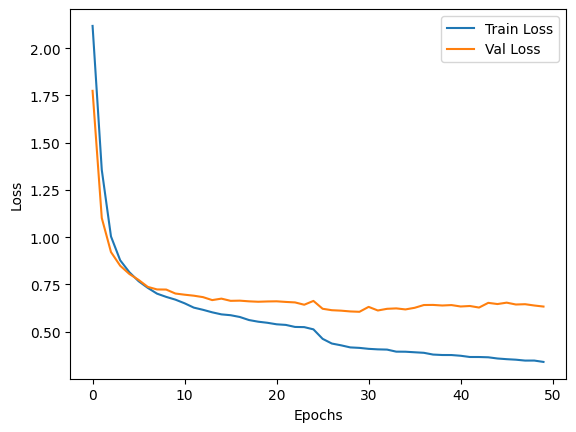

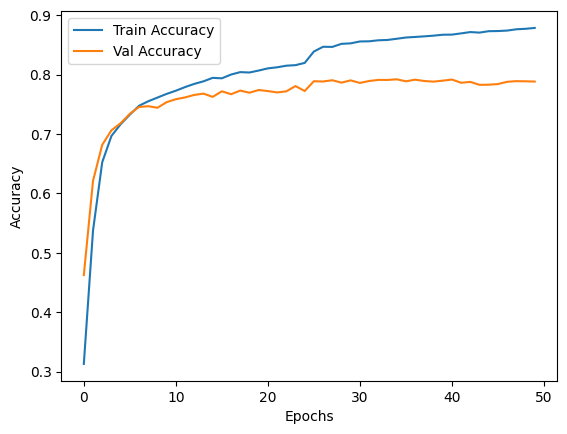

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_2.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

history = train(model_2, trainloader, valloader, optimizer,step_size=25 , epochs=50, verbose=True)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
filename = 'cifar10_model_2.pth'

torch.save(model_2.state_dict(), filename)
print(f"Model saved to {filename}")

NameError: name 'model_2' is not defined

In [ ]:
# model_2 = torch.load(filename)
# model_2.eval()
# print(f"Model loaded from {filename}")

## test

In [ ]:
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
test_loss, test_acc = test(model_2, testloader)

# Optionally, store these metrics for later analysis
history["test_loss"] = test_loss
history["test_acc"] = test_acc

Testing: 100%|██████████| 79/79 [00:11<00:00,  6.81it/s]

Test Loss: 0.6594, Test Accuracy: 0.7910


## statistics


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model_2.eval()  # Set model to evaluation mode
all_labels = []
all_preds = []

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Computing Confusion Matrix"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_2(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Collect all true labels
        all_preds.extend(preds.cpu().numpy())    # Collect all predictions

        # Find misclassified images
        incorrect = preds != labels
        misclassified_images.extend(images[incorrect].cpu())  # Collect misclassified images
        misclassified_labels.extend(labels[incorrect].cpu())  # True labels of misclassified images
        misclassified_preds.extend(preds[incorrect].cpu())  # Predicted labels of misclassified images



Computing Confusion Matrix: 100%|██████████| 79/79 [00:10<00:00,  7.62it/s]


Accuracy for class 0: 0.83
Accuracy for class 1: 0.86
Accuracy for class 2: 0.74
Accuracy for class 3: 0.61
Accuracy for class 4: 0.80
Accuracy for class 5: 0.73
Accuracy for class 6: 0.83
Accuracy for class 7: 0.83
Accuracy for class 8: 0.87
Accuracy for class 9: 0.85


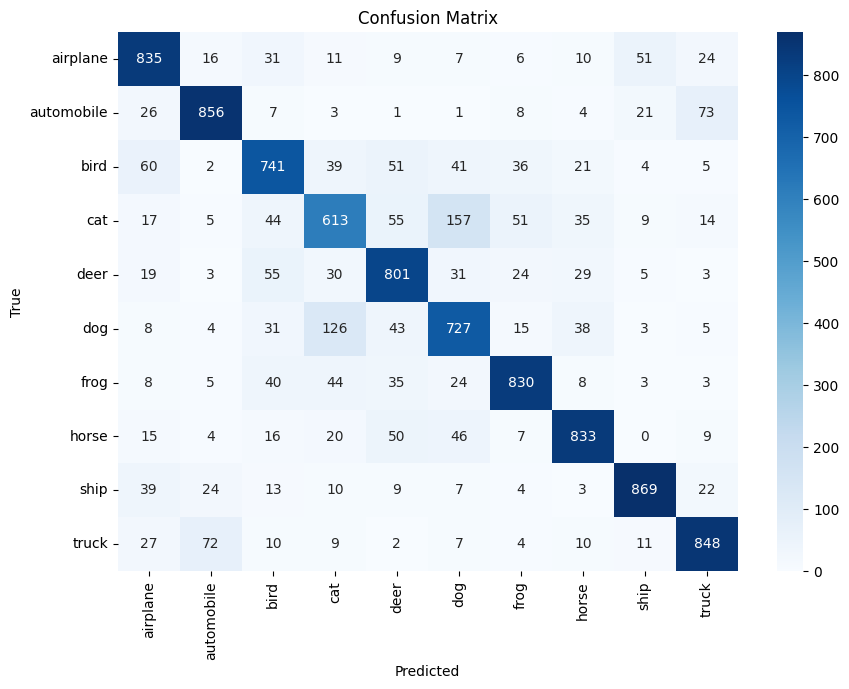

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy for each class
class_accuracies = np.diag(cm) / cm.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {acc:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testloader.dataset.classes, yticklabels=testloader.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

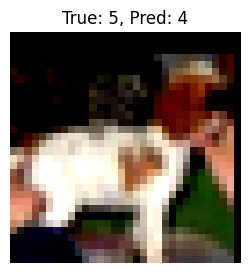

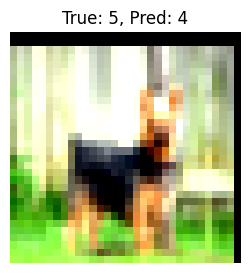

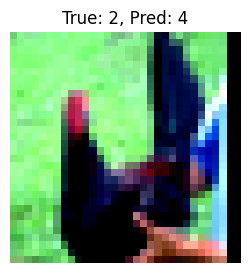

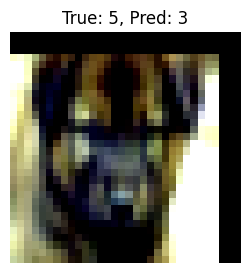

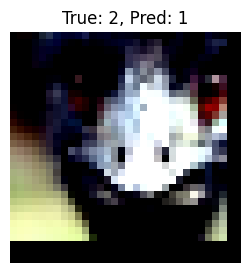

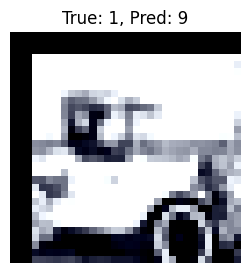

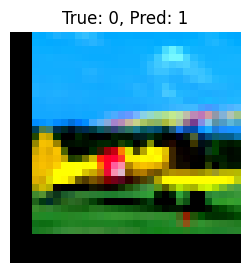

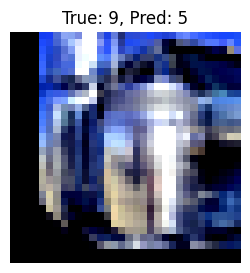

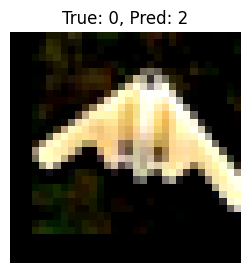

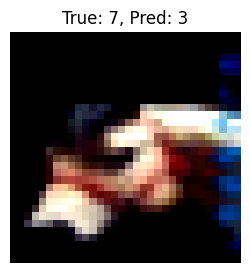

In [ ]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

num_images = 10

for i in range(num_images):
    # Create a new figure for each image
    plt.figure(figsize=(3, 3))

    image = misclassified_images[i].permute(1, 2, 0)  # Convert to (H, W, C)
    image = image * std + mean  # Unnormalize
    image = image.numpy()  # Convert to numpy
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

    plt.imshow(image)
    plt.title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
    plt.axis('off')  # Hide axes
    plt.show()  # Show each image independently

# Model 3



In [11]:
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjust input size based on pooling layers
        self.fc2 = nn.Linear(256, 10)  # Output layer for 10 classes in CIFAR-10

        # Pooling and dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)  # Flatten feature maps for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Example usage
model_3 = SmallCNN()
print(model_3)

num_parameters = sum(value.numel() for value in model_3.state_dict().values())
print(f"Number of parameters: {num_parameters / 10**6:.2f}M")

SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 0.62M


In [12]:
summary(model_3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
          Dropout-11                  [-1, 256]               0
           Linear-12                   [-1, 10]           2,570
Total params: 620,810
Trainable params: 620,810
Non-trainable params: 0
-------------------------------

## train


Epoch 1/70 - Learning Rate: 0.01


Epoch 1/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.42it/s]


Epoch 1/70 - Train Loss: 1.6559, Train Acc: 0.3843 - Val Loss: 1.5348, Val Acc: 0.4331
Epoch 2/70 - Learning Rate: 0.01


Epoch 2/70 (Validation): 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


Epoch 2/70 - Train Loss: 1.3568, Train Acc: 0.5062 - Val Loss: 1.1889, Val Acc: 0.5733
Epoch 3/70 - Learning Rate: 0.01


Epoch 3/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Epoch 3/70 - Train Loss: 1.2207, Train Acc: 0.5593 - Val Loss: 1.1180, Val Acc: 0.5930
Epoch 4/70 - Learning Rate: 0.01


Epoch 4/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Epoch 4/70 - Train Loss: 1.1162, Train Acc: 0.6003 - Val Loss: 1.0887, Val Acc: 0.6157
Epoch 5/70 - Learning Rate: 0.01


Epoch 5/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Epoch 5/70 - Train Loss: 1.0446, Train Acc: 0.6309 - Val Loss: 1.0669, Val Acc: 0.6248
Epoch 6/70 - Learning Rate: 0.01


Epoch 6/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Epoch 6/70 - Train Loss: 0.9841, Train Acc: 0.6525 - Val Loss: 1.0103, Val Acc: 0.6482
Epoch 7/70 - Learning Rate: 0.01


Epoch 7/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 7/70 - Train Loss: 0.9461, Train Acc: 0.6665 - Val Loss: 0.9535, Val Acc: 0.6600
Epoch 8/70 - Learning Rate: 0.01


Epoch 8/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.44it/s]


Epoch 8/70 - Train Loss: 0.9079, Train Acc: 0.6794 - Val Loss: 0.9550, Val Acc: 0.6765
Epoch 9/70 - Learning Rate: 0.01


Epoch 9/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 9/70 - Train Loss: 0.8699, Train Acc: 0.6934 - Val Loss: 0.8328, Val Acc: 0.7107
Epoch 10/70 - Learning Rate: 0.01


Epoch 10/70 (Training): 100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Entire model saved to checkpoint_epoch_10.pth


Epoch 10/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 10/70 - Train Loss: 0.8394, Train Acc: 0.7074 - Val Loss: 0.7727, Val Acc: 0.7291
Epoch 11/70 - Learning Rate: 0.01


Epoch 11/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 11/70 - Train Loss: 0.8114, Train Acc: 0.7171 - Val Loss: 0.8412, Val Acc: 0.7065
Epoch 12/70 - Learning Rate: 0.01


Epoch 12/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Epoch 12/70 - Train Loss: 0.7895, Train Acc: 0.7235 - Val Loss: 0.7692, Val Acc: 0.7311
Epoch 13/70 - Learning Rate: 0.01


Epoch 13/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 13/70 - Train Loss: 0.7690, Train Acc: 0.7326 - Val Loss: 0.7286, Val Acc: 0.7483
Epoch 14/70 - Learning Rate: 0.01


Epoch 14/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch 14/70 - Train Loss: 0.7486, Train Acc: 0.7409 - Val Loss: 0.7119, Val Acc: 0.7501
Epoch 15/70 - Learning Rate: 0.01


Epoch 15/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Epoch 15/70 - Train Loss: 0.7232, Train Acc: 0.7475 - Val Loss: 0.7610, Val Acc: 0.7296
Epoch 16/70 - Learning Rate: 0.01


Epoch 16/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.43it/s]


Epoch 16/70 - Train Loss: 0.7141, Train Acc: 0.7531 - Val Loss: 0.7531, Val Acc: 0.7442
Epoch 17/70 - Learning Rate: 0.01


Epoch 17/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Epoch 17/70 - Train Loss: 0.6920, Train Acc: 0.7606 - Val Loss: 0.7018, Val Acc: 0.7518
Epoch 18/70 - Learning Rate: 0.01


Epoch 18/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Epoch 18/70 - Train Loss: 0.6765, Train Acc: 0.7659 - Val Loss: 0.6545, Val Acc: 0.7782
Epoch 19/70 - Learning Rate: 0.01


Epoch 19/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 19/70 - Train Loss: 0.6649, Train Acc: 0.7718 - Val Loss: 0.6668, Val Acc: 0.7692
Epoch 20/70 - Learning Rate: 0.01


Epoch 20/70 (Training): 100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Entire model saved to checkpoint_epoch_20.pth


Epoch 20/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 20/70 - Train Loss: 0.6578, Train Acc: 0.7712 - Val Loss: 0.6648, Val Acc: 0.7688
Epoch 21/70 - Learning Rate: 0.01


Epoch 21/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.41it/s]


Epoch 21/70 - Train Loss: 0.6445, Train Acc: 0.7776 - Val Loss: 0.6793, Val Acc: 0.7640
Epoch 22/70 - Learning Rate: 0.01


Epoch 22/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Epoch 22/70 - Train Loss: 0.6305, Train Acc: 0.7821 - Val Loss: 0.6338, Val Acc: 0.7814
Epoch 23/70 - Learning Rate: 0.01


Epoch 23/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 23/70 - Train Loss: 0.6201, Train Acc: 0.7860 - Val Loss: 0.6333, Val Acc: 0.7838
Epoch 24/70 - Learning Rate: 0.01


Epoch 24/70 (Validation): 100%|██████████| 79/79 [00:15<00:00,  5.20it/s]


Epoch 24/70 - Train Loss: 0.6090, Train Acc: 0.7887 - Val Loss: 0.6414, Val Acc: 0.7812
Epoch 25/70 - Learning Rate: 0.01


Epoch 25/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 25/70 - Train Loss: 0.6047, Train Acc: 0.7901 - Val Loss: 0.6237, Val Acc: 0.7856
Epoch 26/70 - Learning Rate: 0.01


Epoch 26/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.42it/s]


Epoch 26/70 - Train Loss: 0.5929, Train Acc: 0.7962 - Val Loss: 0.6218, Val Acc: 0.7904
Epoch 27/70 - Learning Rate: 0.01


Epoch 27/70 (Validation): 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]


Epoch 27/70 - Train Loss: 0.5772, Train Acc: 0.8023 - Val Loss: 0.6295, Val Acc: 0.7857
Epoch 28/70 - Learning Rate: 0.01


Epoch 28/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 28/70 - Train Loss: 0.5734, Train Acc: 0.8034 - Val Loss: 0.6180, Val Acc: 0.7923
Epoch 29/70 - Learning Rate: 0.01


Epoch 29/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 29/70 - Train Loss: 0.5708, Train Acc: 0.8052 - Val Loss: 0.5655, Val Acc: 0.8040
Epoch 30/70 - Learning Rate: 0.01


Epoch 30/70 (Training): 100%|██████████| 313/313 [01:56<00:00,  2.70it/s]


Entire model saved to checkpoint_epoch_30.pth


Epoch 30/70 (Validation): 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


Epoch 30/70 - Train Loss: 0.5616, Train Acc: 0.8079 - Val Loss: 0.5948, Val Acc: 0.7971
Epoch 31/70 - Learning Rate: 0.01


Epoch 31/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 31/70 - Train Loss: 0.5502, Train Acc: 0.8129 - Val Loss: 0.5774, Val Acc: 0.8021
Epoch 32/70 - Learning Rate: 0.01


Epoch 32/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.41it/s]


Epoch 32/70 - Train Loss: 0.5504, Train Acc: 0.8101 - Val Loss: 0.5797, Val Acc: 0.7971
Epoch 33/70 - Learning Rate: 0.01


Epoch 33/70 (Validation): 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]


Epoch 33/70 - Train Loss: 0.5493, Train Acc: 0.8105 - Val Loss: 0.5840, Val Acc: 0.8017
Epoch 34/70 - Learning Rate: 0.01


Epoch 34/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.43it/s]


Epoch 34/70 - Train Loss: 0.5359, Train Acc: 0.8162 - Val Loss: 0.5610, Val Acc: 0.8079
Epoch 35/70 - Learning Rate: 0.01


Epoch 35/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.41it/s]


Epoch 35/70 - Train Loss: 0.5299, Train Acc: 0.8176 - Val Loss: 0.6838, Val Acc: 0.7715
Epoch 36/70 - Learning Rate: 0.01


Epoch 36/70 (Validation): 100%|██████████| 79/79 [00:16<00:00,  4.65it/s]


Epoch 36/70 - Train Loss: 0.5280, Train Acc: 0.8190 - Val Loss: 0.6376, Val Acc: 0.7880
Epoch 37/70 - Learning Rate: 0.01


Epoch 37/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 37/70 - Train Loss: 0.5209, Train Acc: 0.8203 - Val Loss: 0.5866, Val Acc: 0.7971
Epoch 38/70 - Learning Rate: 0.01


Epoch 38/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 38/70 - Train Loss: 0.5172, Train Acc: 0.8203 - Val Loss: 0.6072, Val Acc: 0.7934
Epoch 39/70 - Learning Rate: 0.01


Epoch 39/70 (Validation): 100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


Epoch 39/70 - Train Loss: 0.5152, Train Acc: 0.8241 - Val Loss: 0.5513, Val Acc: 0.8087
Epoch 40/70 - Learning Rate: 0.01


Epoch 40/70 (Training): 100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Entire model saved to checkpoint_epoch_40.pth


Epoch 40/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.47it/s]


Epoch 40/70 - Train Loss: 0.5118, Train Acc: 0.8239 - Val Loss: 0.5788, Val Acc: 0.7984
Epoch 41/70 - Learning Rate: 0.005


Epoch 41/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 41/70 - Train Loss: 0.4645, Train Acc: 0.8390 - Val Loss: 0.5084, Val Acc: 0.8254
Epoch 42/70 - Learning Rate: 0.005


Epoch 42/70 (Validation): 100%|██████████| 79/79 [00:16<00:00,  4.87it/s]


Epoch 42/70 - Train Loss: 0.4538, Train Acc: 0.8439 - Val Loss: 0.5385, Val Acc: 0.8110
Epoch 43/70 - Learning Rate: 0.005


Epoch 43/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Epoch 43/70 - Train Loss: 0.4443, Train Acc: 0.8479 - Val Loss: 0.4976, Val Acc: 0.8300
Epoch 44/70 - Learning Rate: 0.005


Epoch 44/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Epoch 44/70 - Train Loss: 0.4421, Train Acc: 0.8481 - Val Loss: 0.4955, Val Acc: 0.8313
Epoch 45/70 - Learning Rate: 0.005


Epoch 45/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch 45/70 - Train Loss: 0.4388, Train Acc: 0.8494 - Val Loss: 0.5168, Val Acc: 0.8204
Epoch 46/70 - Learning Rate: 0.005


Epoch 46/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 46/70 - Train Loss: 0.4357, Train Acc: 0.8503 - Val Loss: 0.5183, Val Acc: 0.8228
Epoch 47/70 - Learning Rate: 0.005


Epoch 47/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 47/70 - Train Loss: 0.4283, Train Acc: 0.8512 - Val Loss: 0.5057, Val Acc: 0.8278
Epoch 48/70 - Learning Rate: 0.005


Epoch 48/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 48/70 - Train Loss: 0.4277, Train Acc: 0.8533 - Val Loss: 0.5116, Val Acc: 0.8269
Epoch 49/70 - Learning Rate: 0.005


Epoch 49/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Epoch 49/70 - Train Loss: 0.4258, Train Acc: 0.8541 - Val Loss: 0.5561, Val Acc: 0.8165
Epoch 50/70 - Learning Rate: 0.005


Epoch 50/70 (Training): 100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Entire model saved to checkpoint_epoch_50.pth


Epoch 50/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 50/70 - Train Loss: 0.4293, Train Acc: 0.8504 - Val Loss: 0.4861, Val Acc: 0.8348
Epoch 51/70 - Learning Rate: 0.005


Epoch 51/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.45it/s]


Epoch 51/70 - Train Loss: 0.4172, Train Acc: 0.8566 - Val Loss: 0.4928, Val Acc: 0.8275
Epoch 52/70 - Learning Rate: 0.005


Epoch 52/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 52/70 - Train Loss: 0.4236, Train Acc: 0.8538 - Val Loss: 0.5045, Val Acc: 0.8257
Epoch 53/70 - Learning Rate: 0.005


Epoch 53/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.47it/s]


Epoch 53/70 - Train Loss: 0.4181, Train Acc: 0.8562 - Val Loss: 0.5056, Val Acc: 0.8260
Epoch 54/70 - Learning Rate: 0.005


Epoch 54/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch 54/70 - Train Loss: 0.4169, Train Acc: 0.8546 - Val Loss: 0.4787, Val Acc: 0.8405
Epoch 55/70 - Learning Rate: 0.005


Epoch 55/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Epoch 55/70 - Train Loss: 0.4148, Train Acc: 0.8555 - Val Loss: 0.5105, Val Acc: 0.8269
Epoch 56/70 - Learning Rate: 0.005


Epoch 56/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.42it/s]


Epoch 56/70 - Train Loss: 0.4090, Train Acc: 0.8600 - Val Loss: 0.5077, Val Acc: 0.8246
Epoch 57/70 - Learning Rate: 0.005


Epoch 57/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch 57/70 - Train Loss: 0.4069, Train Acc: 0.8589 - Val Loss: 0.4898, Val Acc: 0.8330
Epoch 58/70 - Learning Rate: 0.005


Epoch 58/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.45it/s]


Epoch 58/70 - Train Loss: 0.4151, Train Acc: 0.8569 - Val Loss: 0.4980, Val Acc: 0.8326
Epoch 59/70 - Learning Rate: 0.005


Epoch 59/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.44it/s]


Epoch 59/70 - Train Loss: 0.4067, Train Acc: 0.8587 - Val Loss: 0.5511, Val Acc: 0.8119
Epoch 60/70 - Learning Rate: 0.005


Epoch 60/70 (Training): 100%|██████████| 313/313 [01:55<00:00,  2.71it/s]


Entire model saved to checkpoint_epoch_60.pth


Epoch 60/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch 60/70 - Train Loss: 0.4113, Train Acc: 0.8581 - Val Loss: 0.5269, Val Acc: 0.8227
Epoch 61/70 - Learning Rate: 0.005


Epoch 61/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.47it/s]


Epoch 61/70 - Train Loss: 0.4063, Train Acc: 0.8600 - Val Loss: 0.4945, Val Acc: 0.8354
Epoch 62/70 - Learning Rate: 0.005


Epoch 62/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.41it/s]


Epoch 62/70 - Train Loss: 0.4034, Train Acc: 0.8620 - Val Loss: 0.5075, Val Acc: 0.8274
Epoch 63/70 - Learning Rate: 0.005


Epoch 63/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.43it/s]


Epoch 63/70 - Train Loss: 0.4067, Train Acc: 0.8592 - Val Loss: 0.4886, Val Acc: 0.8309
Epoch 64/70 - Learning Rate: 0.005


Epoch 64/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.40it/s]


Epoch 64/70 - Train Loss: 0.4076, Train Acc: 0.8601 - Val Loss: 0.4910, Val Acc: 0.8330
Epoch 65/70 - Learning Rate: 0.005


Epoch 65/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 65/70 - Train Loss: 0.4031, Train Acc: 0.8613 - Val Loss: 0.4820, Val Acc: 0.8338
Epoch 66/70 - Learning Rate: 0.005


Epoch 66/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 66/70 - Train Loss: 0.3998, Train Acc: 0.8633 - Val Loss: 0.4841, Val Acc: 0.8350
Epoch 67/70 - Learning Rate: 0.005


Epoch 67/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.43it/s]


Epoch 67/70 - Train Loss: 0.3969, Train Acc: 0.8620 - Val Loss: 0.4827, Val Acc: 0.8351
Epoch 68/70 - Learning Rate: 0.005


Epoch 68/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 68/70 - Train Loss: 0.3976, Train Acc: 0.8618 - Val Loss: 0.5422, Val Acc: 0.8209
Epoch 69/70 - Learning Rate: 0.005


Epoch 69/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.46it/s]


Epoch 69/70 - Train Loss: 0.3962, Train Acc: 0.8630 - Val Loss: 0.4817, Val Acc: 0.8360
Epoch 70/70 - Learning Rate: 0.005


Epoch 70/70 (Training): 100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Entire model saved to checkpoint_epoch_70.pth


Epoch 70/70 (Validation): 100%|██████████| 79/79 [00:14<00:00,  5.40it/s]


Epoch 70/70 - Train Loss: 0.3951, Train Acc: 0.8636 - Val Loss: 0.4768, Val Acc: 0.8355


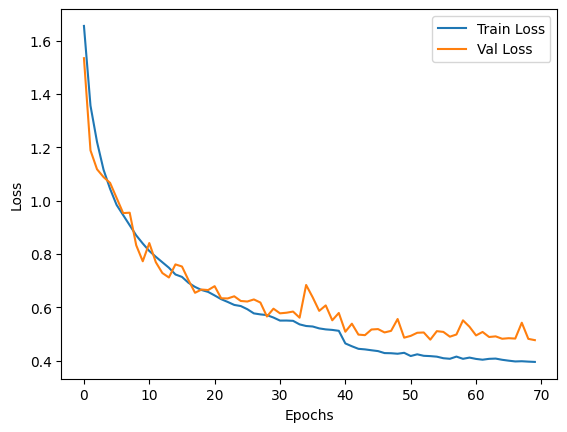

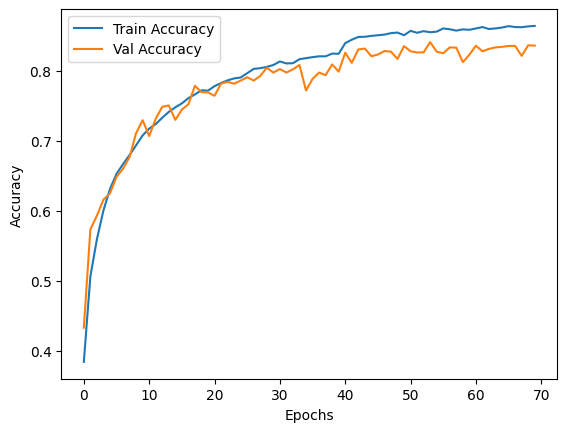

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_3.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

history = train(model_3, trainloader, valloader, optimizer, step_size=40 , epochs=70, verbose=True)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
filename = 'cifar10_model_3.pth'

torch.save(model_3.state_dict(), filename)
print(f"Model saved to {filename}")

Model saved to cifar10_model_3.pth


In [15]:
# model_2 = torch.load(filename)
# model_2.eval()
# print(f"Model loaded from {filename}")

## test

In [16]:
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
test_loss, test_acc = test(model_3, testloader)

# Optionally, store these metrics for later analysis
history["test_loss"] = test_loss
history["test_acc"] = test_acc

Testing: 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]

Test Loss: 0.4945, Test Accuracy: 0.8295


## statistics


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model_3.eval()  # Set model to evaluation mode
all_labels = []
all_preds = []

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Computing Confusion Matrix"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_3(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Collect all true labels
        all_preds.extend(preds.cpu().numpy())    # Collect all predictions

        # Find misclassified images
        incorrect = preds != labels
        misclassified_images.extend(images[incorrect].cpu())  # Collect misclassified images
        misclassified_labels.extend(labels[incorrect].cpu())  # True labels of misclassified images
        misclassified_preds.extend(preds[incorrect].cpu())  # Predicted labels of misclassified images



Computing Confusion Matrix: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Accuracy for class 0: 0.85
Accuracy for class 1: 0.89
Accuracy for class 2: 0.74
Accuracy for class 3: 0.69
Accuracy for class 4: 0.85
Accuracy for class 5: 0.75
Accuracy for class 6: 0.87
Accuracy for class 7: 0.89
Accuracy for class 8: 0.92
Accuracy for class 9: 0.88


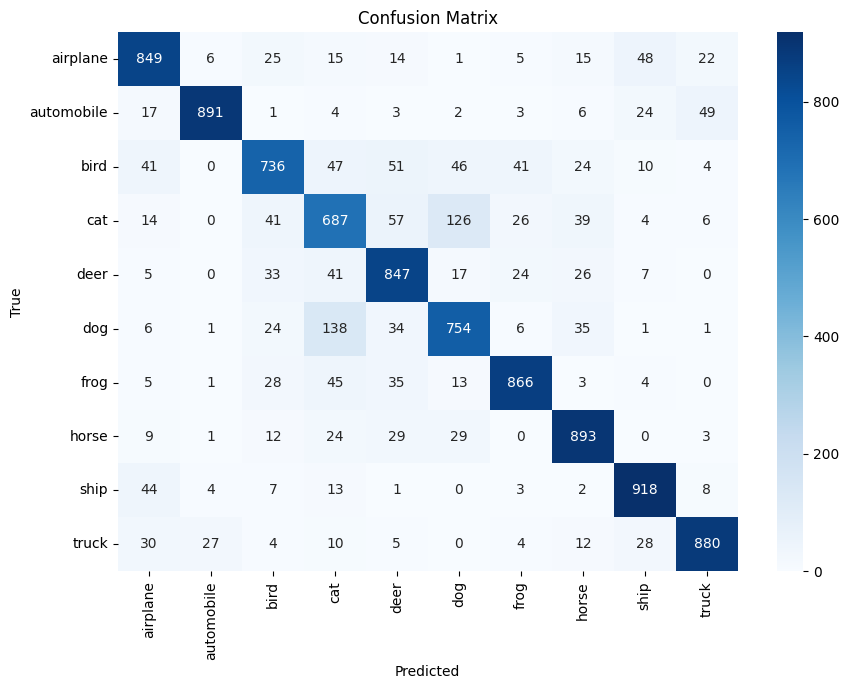

In [18]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy for each class
class_accuracies = np.diag(cm) / cm.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {acc:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testloader.dataset.classes, yticklabels=testloader.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()